# Overview

*   This program(code) focuses on developing a text classification model to detect
emotions—joy, fear, love, anger, sadness, and surprise—from text data. It begins by loading and preprocessing an emotions dataset, where the text is tokenized using a pre-trained model. The core of the program involves training a transformer-based model (such as BERT), followed by fine-tuning to enhance its ability to classify emotions accurately. After training, the model is validated on a test set, and it can then be used to predict emotions from new text inputs with high precision.

---

In [1]:
!pip install transformers datasets torch scikit-learn

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

#Methodology

---
---


*     Installing the all necessary libraries
---

In [2]:
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Loading the ***Emotion dataset*** from Hugging Face 🤗

---





In [3]:
# Loading the Emotion dataset
dataset = load_dataset("emotion")

# Checking the structure of the dataset
print(dataset)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [4]:
print("Train Dataset Head:")
print(dataset['train'].to_pandas().head(8))

print("\nValidation Dataset Head:")
print(dataset['validation'].to_pandas().head(8))

print("\nTest Dataset Head:")
print(dataset['test'].to_pandas().head(8))


Train Dataset Head:
                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3
5  ive been feeling a little burdened lately wasn...      0
6  ive been taking or milligrams or times recomme...      5
7  i feel as confused about life as a teenager or...      4

Validation Dataset Head:
                                                text  label
0  im feeling quite sad and sorry for myself but ...      0
1  i feel like i am still looking at a blank canv...      0
2                     i feel like a faithful servant      2
3                  i am just feeling cranky and blue      3
4  i can have for a treat or if i am feeling festive      1
5  i start to feel more appreciative of what god ...  

#Label Distribution Across Dataset

---



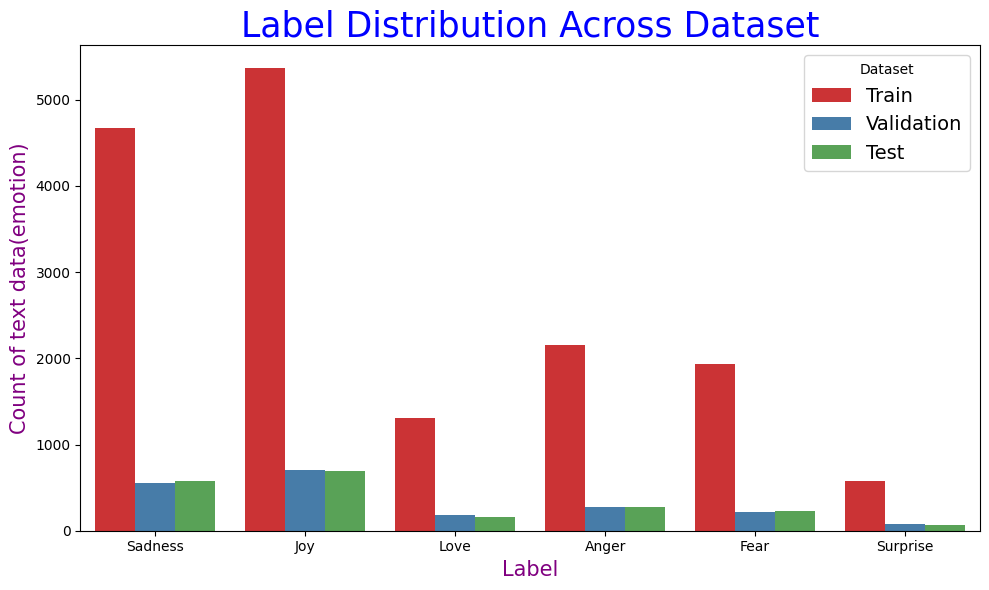

In [5]:
# Converting the datasets to Pandas DataFrames and add a column indicating the dataset
train_df = dataset['train'].to_pandas()
train_df['dataset'] = 'Train'

val_df = dataset['validation'].to_pandas()
val_df['dataset'] = 'Validation'

test_df = dataset['test'].to_pandas()
test_df['dataset'] = 'Test'

# Combine all dataframes into a single dataframe
combined_df = pd.concat([train_df, val_df, test_df])

# Ploting the graph of combined data
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, x='label', hue='dataset', palette='Set1')
plt.title('Label Distribution Across Dataset', fontsize=25, color="blue")
plt.xlabel('Label', fontsize=15, color="purple")
plt.ylabel('Count of text data(emotion)', fontsize=15, color="purple")
plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise'])
plt.legend(title='Dataset', fontsize=14)

plt.tight_layout()
plt.show()


# Training and Fine Tuning

---
---

In [6]:
from transformers import BertTokenizer

# Loading the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenizing the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Prepare the tokenized datasets for training
train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [7]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer

# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [9]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }


In [10]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


# RESULTS

---



In [11]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.237400,0.210073,0.926000,0.886115,0.877919,0.899625
2,0.117100,0.175055,0.924500,0.879359,0.880449,0.878504


TrainOutput(global_step=2000, training_loss=0.316131276383996, metrics={'train_runtime': 3098.9774, 'train_samples_per_second': 10.326, 'train_steps_per_second': 0.645, 'total_flos': 8419856154624000.0, 'train_loss': 0.316131276383996, 'epoch': 2.0})

In [12]:
!pip install transformers torch

# Prediction
---




In [25]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Step 1: Load the pre-trained emotion classification model and tokenizer
model_name = "bhadresh-savani/bert-base-uncased-emotion"  # Example model
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Step 2: Move the model to the appropriate device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Defining the emotion labels (ensure this matches your model's labels)
emotion_labels = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']

# Function to predict emotion from input text
def predict_emotion(input_text):
    # Step 3: Prepare your input text and move the input tensors to the same device
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

    # Step 4: Run the model without computing gradients
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        print(f"Logits: {logits}")  # Print logits for debugging
        predicted_class_id = torch.argmax(logits, dim=1).item()

    # Step 5: Map the predicted class ID to the emotion label
    predicted_label = emotion_labels[predicted_class_id]

    # Step 6: Output the results
    return predicted_label

# Test with different input texts
test_texts = [
    "I feel a deep sense of gratitude for all the support I've received.",
    "The argument with my friend left me feeling quite angry and upset.",
    "I was astonished and amazed by the unexpected twist in the plot!"
    "I'm finally feeling at peace.",
    "I just can't get enough of how wonderful this vacation has been!",
    "The movie was so sad.",
    "I was totally shocked when I heard the surprise announcement!"
]

# Print predictions for each test text
for text in test_texts:
    predicted_emotion = predict_emotion(text)
    print(f"Input Text: {text}")
    print(f"Predicted Emotion: {predicted_emotion}\n")


config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Logits: tensor([[-1.7563,  4.6193,  4.0820, -2.3124, -2.7509, -1.8652]],
       device='cuda:0')
Input Text: I feel a deep sense of gratitude for all the support I've received.
Predicted Emotion: Joy

Logits: tensor([[-1.3396, -2.3782, -1.9300,  6.2656,  0.3360, -1.8118]],
       device='cuda:0')
Input Text: The argument with my friend left me feeling quite angry and upset.
Predicted Emotion: Anger

Logits: tensor([[-1.3794,  7.0695, -0.8386, -2.4294, -1.9563, -0.3657]],
       device='cuda:0')
Input Text: I was astonished and amazed by the unexpected twist in the plot!I'm finally feeling at peace.
Predicted Emotion: Joy

Logits: tensor([[-1.4986,  6.9153, -1.1825, -2.0972, -2.0424, -0.3951]],
       device='cuda:0')
Input Text: I just can't get enough of how wonderful this vacation has been!
Predicted Emotion: Joy

Logits: tensor([[ 6.8164, -1.5609, -1.1867, -1.0350, -0.9752, -1.7284]],
       device='cuda:0')
Input Text: The movie was so sad.
Predicted Emotion: Sadness

Logits: tenso